In [1]:
"""Run a YOLO_v2 style detection model on test images."""
import cv2
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.models import load_model

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from yad2k.models.keras_yolo import yolo_eval, yolo_head

In [3]:
class YOLO(object):
    def __init__(self):
        self.model_path = 'model_data/yolo.h5'
        self.anchors_path = 'model_data/yolo_anchors.txt'
        self.classes_path = 'model_data/coco_classes.txt'
        self.score = 0.3
        self.iou = 0.5

        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
            anchors = [float(x) for x in anchors.split(',')]
            anchors = np.array(anchors).reshape(-1, 2)
        return anchors

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model must be a .h5 file.'

        self.yolo_model = load_model(model_path)

        # Verify model, anchors, and classes are compatible
        num_classes = len(self.class_names)
        num_anchors = len(self.anchors)
        # TODO: Assumes dim ordering is channel last
        model_output_channels = self.yolo_model.layers[-1].output_shape[-1]
        assert model_output_channels == num_anchors * (num_classes + 5), \
            'Mismatch between model and given anchor and class sizes'
        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Check if model is fully convolutional, assuming channel last order.
        self.model_image_size = self.yolo_model.layers[0].input_shape[1:3]
        self.is_fixed_size = self.model_image_size != (None, None)

        # Generate output tensor targets for filtered bounding boxes.
        # TODO: Wrap these backend operations with Keras layers.
        yolo_outputs = yolo_head(self.yolo_model.output, self.anchors, len(self.class_names))
        self.input_image_shape = K.placeholder(shape=(2, ))
        boxes, scores, classes = yolo_eval(yolo_outputs, self.input_image_shape, score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = time.time()
        y, x, _ = image.shape

        if self.is_fixed_size:  # TODO: When resizing we can use minibatch input.
            resized_image = cv2.resize(image, tuple(reversed(self.model_image_size)), interpolation=cv2.INTER_CUBIC)
            image_data = np.array(resized_image, dtype='float32')
        else:
            image_data = np.array(image, dtype='float32')

        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.shape[0], image.shape[1]],
                K.learning_phase(): 0
            })
        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(y, np.floor(bottom + 0.5).astype('int32'))
            right = min(x, np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            cv2.rectangle(image, (left, top), (right, bottom), (255, 0, 0), 2)
            cv2.putText(image, label, (left, int(top - 4)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        end = time.time()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()


def detect_vedio(video, yolo):
    camera = cv2.VideoCapture(video)
    cv2.namedWindow("detection", cv2.WINDOW_NORMAL)
    while True:
        res, frame = camera.read()

        if not res:
            break

        image = yolo.detect_image(frame)
        cv2.imshow("detection", image)
        if cv2.waitKey(110) & 0xff == 27:
                break
    yolo.close_session()

def detect_img(img, yolo):
    image = cv2.imread(img)
    r_image = yolo.detect_image(image)
    cv2.namedWindow("detection")
    while True:
        cv2.imshow("detection", r_image)
        if cv2.waitKey(110) & 0xff == 27:
                break
    yolo.close_session()

In [4]:
yolo = YOLO()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


model_data/yolo.h5 model, anchors, and classes loaded.


In [ ]:
imgpath = 'images/testcar.jpeg'

In [ ]:
imgpath

In [ ]:
image = plt.imread(imgpath)
r_image = yolo.detect_image(image)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(r_image)
plt.savefig("test.jpg")
plt.show()

In [5]:
imgpath1 = 'images/eagle.jpg'

Found 1 boxes for img
bird 0.90 (141, 86) (618, 447)
0.5115468502044678


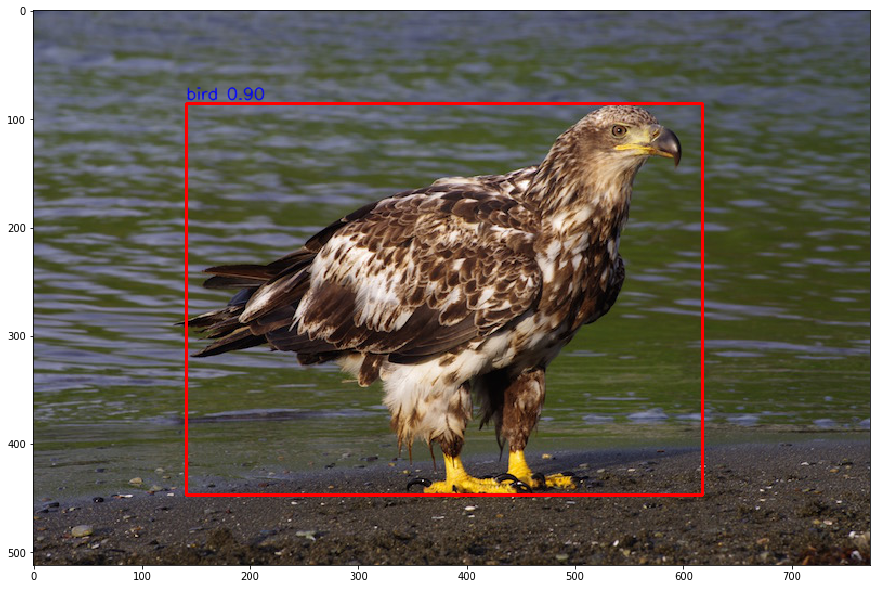

In [7]:
image1 = plt.imread(imgpath1)
r_image = yolo.detect_image(image1)
plt.figure(figsize=(15,15))
plt.imshow(r_image)
plt.show()

In [5]:
video = "./project_video.mp4"

In [ ]:
detect_vedio(video,yolo)

In [6]:
camera = cv2.VideoCapture(video)

In [ ]:
while True:
    res, frame = camera.read()

    if not res:
        break

    image = yolo.detect_image(frame)
    cv2.imshow("detection", image)
    if cv2.waitKey(110) & 0xff == 27:
        break